# Assignment: Movie Ratings & Revenue Analysis

Step 1: Create the CSV – movies.csv

In [1]:
data = """MovieID,Title,Genre,ReleaseDate,Rating,Revenue,Budget
1,Inception,Sci-Fi,2010-07-16,8.8,825532764,160000000
2,The Dark Knight,Action,2008-07-18,9.0,1004558444,185000000
3,Titanic,Romance,1997-12-19,7.8,2187463944,200000000
4,Interstellar,Sci-Fi,2014-11-07,8.6,677471339,165000000
5,Joker,Drama,2019-10-04,8.4,1074251311,55000000
6,The Notebook,Romance,2004-06-25,7.9,,29000000
7,Avengers: Endgame,Action,2019-04-26,8.4,2797800564,356000000"""

with open("movies.csv", "w") as f:
    f.write(data)


# PART 1: Pandas Operations

1. Load CSV into Pandas


In [2]:
import pandas as pd
df = pd.read_csv("movies.csv")

2. Convert ReleaseDate to datetime

In [3]:
df["ReleaseDate"] = pd.to_datetime(df["ReleaseDate"])

3. Create Profit = Revenue - Budget

In [4]:
df["Profit"] = df["Revenue"] - df["Budget"]

4. Add column Era:

In [5]:
def get_era(date):
  year = date.year
  if year<2000:
    return "Classic"
  elif year<=2010:
    return "Mid"
  else:
    return "Modern"

df["Era"]= df["ReleaseDate"].apply(get_era)

 5. Handle nulls in Revenue by filling with average revenue.

In [7]:
df["Revenue"] = df["Revenue"].fillna(df["Revenue"].mean())
print(df["Revenue"])

0    8.255328e+08
1    1.004558e+09
2    2.187464e+09
3    6.774713e+08
4    1.074251e+09
5    1.427846e+09
6    2.797801e+09
Name: Revenue, dtype: float64


6. Sort by Rating descending

In [9]:
df_sorted= df.sort_values(by="Rating", ascending=False)
print(df_sorted[["Title","Rating"]])

               Title  Rating
1    The Dark Knight     9.0
0          Inception     8.8
3       Interstellar     8.6
6  Avengers: Endgame     8.4
4              Joker     8.4
5       The Notebook     7.9
2            Titanic     7.8


7. Group by Genre: avg Rating & total Revenue

In [13]:
grouped = df.groupby("Genre").agg({"Rating": "mean", "Revenue": "sum"})
print(grouped)

         Rating       Revenue
Genre                        
Action     8.70  3.802359e+09
Drama      8.40  1.074251e+09
Romance    7.85  3.615310e+09
Sci-Fi     8.70  1.503004e+09


8. Filter movies with Rating ≥ 8.5 and Profit > 500M



In [16]:
filtered_df = df[(df["Rating"]>=8.5) & (df["Profit"]>500_000_000)]
print(filtered_df)

   MovieID            Title   Genre ReleaseDate  Rating       Revenue  \
0        1        Inception  Sci-Fi  2010-07-16     8.8  8.255328e+08   
1        2  The Dark Knight  Action  2008-07-18     9.0  1.004558e+09   
3        4     Interstellar  Sci-Fi  2014-11-07     8.6  6.774713e+08   

      Budget       Profit     Era  
0  160000000  665532764.0     Mid  
1  185000000  819558444.0     Mid  
3  165000000  512471339.0  Modern  


9. Bar Chart: Movie Title vs Profit

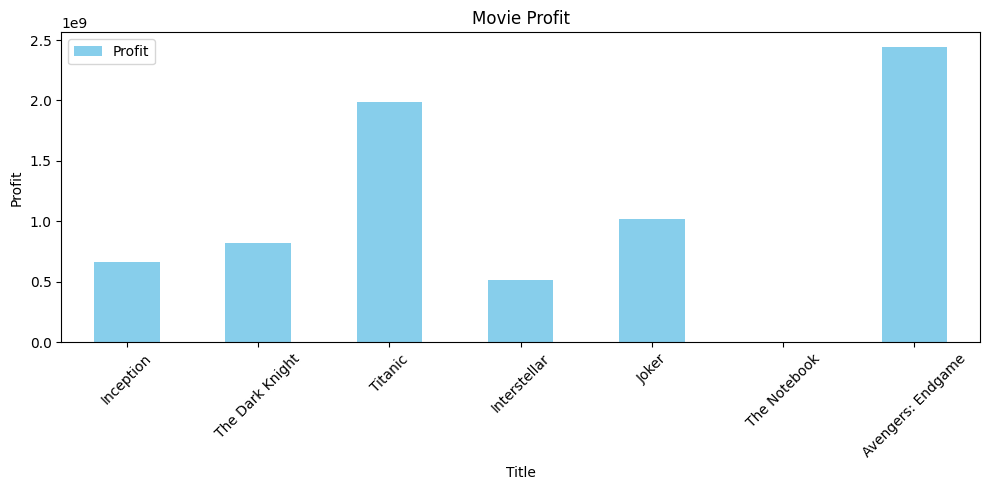

In [19]:
import matplotlib.pyplot as plt
df.plot(x="Title", y="Profit", kind="bar", color="skyblue", figsize=(10,5))
plt.title("Movie Profit")
plt.xlabel("Title")
plt.ylabel("Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# PART 2: PySpark Operations

In [20]:
# Download Spark from the correct URL
!wget https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz



--2025-07-31 09:27:58--  https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400395283 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.0-bin-hadoop3.tgz’

spark-3.5.0-bin-had 100%[===================>] 381.85M  1.38MB/s    in 7m 39s  

2025-07-31 09:35:38 (852 KB/s) - ‘spark-3.5.0-bin-hadoop3.tgz’ saved [400395283/400395283]



In [21]:
# Extract Spark
!tar -xzf spark-3.5.0-bin-hadoop3.tgz

In [22]:
!apt-get install openjdk-11-jdk -y
!pip install -q findspark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 5,367 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [24]:
#Set Environment Variables and Initialize Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MovieRatingAnalysis").getOrCreate()

1. Read the CSV with PySpark

In [25]:
df = spark.read.csv("movies.csv", header=True, inferSchema=True)
df.printSchema()
df.show()

root
 |-- MovieID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- ReleaseDate: date (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Revenue: long (nullable = true)
 |-- Budget: integer (nullable = true)

+-------+-----------------+-------+-----------+------+----------+---------+
|MovieID|            Title|  Genre|ReleaseDate|Rating|   Revenue|   Budget|
+-------+-----------------+-------+-----------+------+----------+---------+
|      1|        Inception| Sci-Fi| 2010-07-16|   8.8| 825532764|160000000|
|      2|  The Dark Knight| Action| 2008-07-18|   9.0|1004558444|185000000|
|      3|          Titanic|Romance| 1997-12-19|   7.8|2187463944|200000000|
|      4|     Interstellar| Sci-Fi| 2014-11-07|   8.6| 677471339|165000000|
|      5|            Joker|  Drama| 2019-10-04|   8.4|1074251311| 55000000|
|      6|     The Notebook|Romance| 2004-06-25|   7.9|      NULL| 29000000|
|      7|Avengers: Endgame| Action| 2019-

2. Create Profit column (Revenue - Budget)

In [26]:
from pyspark.sql.functions import col
df = df.withColumn("Profit", col("Revenue") - col("Budget"))
df.select("Title","Revenue", "Budget", "Profit").show()

+-----------------+----------+---------+----------+
|            Title|   Revenue|   Budget|    Profit|
+-----------------+----------+---------+----------+
|        Inception| 825532764|160000000| 665532764|
|  The Dark Knight|1004558444|185000000| 819558444|
|          Titanic|2187463944|200000000|1987463944|
|     Interstellar| 677471339|165000000| 512471339|
|            Joker|1074251311| 55000000|1019251311|
|     The Notebook|      NULL| 29000000|      NULL|
|Avengers: Endgame|2797800564|356000000|2441800564|
+-----------------+----------+---------+----------+



3. Filter where Genre = 'Sci-Fi' and Profit > 500000000

In [27]:
df.filter((col("Genre") == "Sci-Fi") & (col("Profit") > 500_000_000)).show()


+-------+------------+------+-----------+------+---------+---------+---------+
|MovieID|       Title| Genre|ReleaseDate|Rating|  Revenue|   Budget|   Profit|
+-------+------------+------+-----------+------+---------+---------+---------+
|      1|   Inception|Sci-Fi| 2010-07-16|   8.8|825532764|160000000|665532764|
|      4|Interstellar|Sci-Fi| 2014-11-07|   8.6|677471339|165000000|512471339|
+-------+------------+------+-----------+------+---------+---------+---------+



 4. Group by Genre → avg(Rating), sum(Profit)

In [28]:
df.groupby("Genre").agg({"Rating": "avg", "Profit": "sum"}).show()

+-------+-----------+-----------+
|  Genre|avg(Rating)|sum(Profit)|
+-------+-----------+-----------+
|Romance|       7.85| 1987463944|
|  Drama|        8.4| 1019251311|
| Action|        8.7| 3261359008|
| Sci-Fi|        8.7| 1178004103|
+-------+-----------+-----------+



 5. Classify Rating as
 9 → Blockbuster
 8–9 → Hit
 below 8 → Average


In [38]:
from pyspark.sql.functions import when

df = df.withColumn("RatingCategory",
    when(col("Rating") == 9.0, "Blockbuster")
    .when((col("Rating") >= 8.0) & (col("Rating") < 9.0), "Hit")
    .otherwise("Average")
)

df.select("Title", "Rating", "RatingCategory").show()

+-----------------+------+--------------+
|            Title|Rating|RatingCategory|
+-----------------+------+--------------+
|        Inception|   8.8|           Hit|
|  The Dark Knight|   9.0|   Blockbuster|
|          Titanic|   7.8|       Average|
|     Interstellar|   8.6|           Hit|
|            Joker|   8.4|           Hit|
|     The Notebook|   7.9|       Average|
|Avengers: Endgame|   8.4|           Hit|
+-----------------+------+--------------+



6. Drop the Budget column



In [37]:
df.drop("Budget")

DataFrame[MovieID: int, Title: string, Genre: string, ReleaseDate: date, Rating: double, Revenue: bigint, Profit: bigint, PRofitRank: int, Year: int, Month: int]

7. Fill nulls in Revenue with average

In [40]:
avg_revenue = df.selectExpr("avg(Revenue)").first()[0]
df = df.na.fill({"Revenue":avg_revenue})

 8. Convert ReleaseDate to date type, extract year and month

In [41]:
from pyspark.sql.functions import to_date, year, month

df = df.withColumn("ReleaseDate", to_date(col("ReleaseDate"), "yyyy-mm-dd"))
df = df.withColumn("Year", year(col("ReleaseDate")))
df = df.withColumn("Month",month(col("ReleaseDate")))
df.select("Title", "ReleaseDate", "Year", "Month").show()

+-----------------+-----------+----+-----+
|            Title|ReleaseDate|Year|Month|
+-----------------+-----------+----+-----+
|        Inception| 2010-07-16|2010|    7|
|  The Dark Knight| 2008-07-18|2008|    7|
|          Titanic| 1997-12-19|1997|   12|
|     Interstellar| 2014-11-07|2014|   11|
|            Joker| 2019-10-04|2019|   10|
|     The Notebook| 2004-06-25|2004|    6|
|Avengers: Endgame| 2019-04-26|2019|    4|
+-----------------+-----------+----+-----+



9. Use Window Function: Rank movies within each genre by Profit

In [42]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

windowSpec = Window.partitionBy("Genre").orderBy(col("Profit").desc())

df = df.withColumn("PRofitRank", rank().over(windowSpec))
df.select("Title", "Genre", "Profit", "ProfitRank").show()

+-----------------+-------+----------+----------+
|            Title|  Genre|    Profit|ProfitRank|
+-----------------+-------+----------+----------+
|Avengers: Endgame| Action|2441800564|         1|
|  The Dark Knight| Action| 819558444|         2|
|            Joker|  Drama|1019251311|         1|
|          Titanic|Romance|1987463944|         1|
|     The Notebook|Romance|      NULL|         2|
|        Inception| Sci-Fi| 665532764|         1|
|     Interstellar| Sci-Fi| 512471339|         2|
+-----------------+-------+----------+----------+



PART 3: JSON + UNION Example

Data provided

In [ ]:
[
  {
    "MovieID": 8,
    "Title": "Barbie",
    "Genre": "Drama",
    "Rating": 7.5,
    "Revenue": 1456000000,
    "Budget": 145000000
  },
  {
    "MovieID": 9,
    "Title": "Oppenheimer",
    "Genre": "Drama",
    "Rating": 8.6,
    "Revenue": 950000000,
    "Budget": 100000000
  }
]


 Step 1: Saving data as movies_bonus.json


In [43]:
json_data = """
[
  {
    "MovieID": 8,
    "Title": "Barbie",
    "Genre": "Drama",
    "Rating": 7.5,
    "Revenue": 1456000000,
    "Budget": 145000000
  },
  {
    "MovieID": 9,
    "Title": "Oppenheimer",
    "Genre": "Drama",
    "Rating": 8.6,
    "Revenue": 950000000,
    "Budget": 100000000
  }
]
"""

with open("movies_bonus.json", "w") as f:
    f.write(json_data)


 1. Read this JSON using PySpark

In [44]:
df_json = spark.read.json("movies_bonus.json", multiLine=True)
df_json.show()


+---------+-----+-------+------+----------+-----------+
|   Budget|Genre|MovieID|Rating|   Revenue|      Title|
+---------+-----+-------+------+----------+-----------+
|145000000|Drama|      8|   7.5|1456000000|     Barbie|
|100000000|Drama|      9|   8.6| 950000000|Oppenheimer|
+---------+-----+-------+------+----------+-----------+



2. Union it with original movies DataFrame

In [60]:
# Re- reading csv as budget is dropped
from pyspark.sql.functions import col

original_df = spark.read.csv("movies.csv", header=True, inferSchema=True)
original_df = original_df.withColumn("Profit", col("Revenue") - col("Budget"))



In [61]:
df_json = spark.read.json("movies_bonus.json", multiLine=True)
df_json = df_json.withColumn("Profit", col("Revenue") - col("Budget"))


In [62]:
from pyspark.sql.functions import lit

df_json = df_json.withColumn("ReleaseDate", lit(None).cast("string"))


In [63]:
df_json = df_json.select(original_df.columns)


In [64]:
union_df = original_df.unionByName(df_json)
union_df.show()

+-------+-----------------+-------+-----------+------+----------+---------+----------+
|MovieID|            Title|  Genre|ReleaseDate|Rating|   Revenue|   Budget|    Profit|
+-------+-----------------+-------+-----------+------+----------+---------+----------+
|      1|        Inception| Sci-Fi| 2010-07-16|   8.8| 825532764|160000000| 665532764|
|      2|  The Dark Knight| Action| 2008-07-18|   9.0|1004558444|185000000| 819558444|
|      3|          Titanic|Romance| 1997-12-19|   7.8|2187463944|200000000|1987463944|
|      4|     Interstellar| Sci-Fi| 2014-11-07|   8.6| 677471339|165000000| 512471339|
|      5|            Joker|  Drama| 2019-10-04|   8.4|1074251311| 55000000|1019251311|
|      6|     The Notebook|Romance| 2004-06-25|   7.9|      NULL| 29000000|      NULL|
|      7|Avengers: Endgame| Action| 2019-04-26|   8.4|2797800564|356000000|2441800564|
|      8|           Barbie|  Drama|       NULL|   7.5|1456000000|145000000|1311000000|
|      9|      Oppenheimer|  Drama|       N

3. Show top 5 highest grossing movies

In [50]:
union_df.orderBy(col("Revenue").desc()).select("Title", "Revenue").show(5)


+-----------------+----------+
|            Title|   Revenue|
+-----------------+----------+
|Avengers: Endgame|2797800564|
|          Titanic|2187463944|
|           Barbie|1456000000|
|            Joker|1074251311|
|  The Dark Knight|1004558444|
+-----------------+----------+
only showing top 5 rows



4. Save final merged DataFrame as CSV

In [51]:
union_df.write.csv("merged_movies.csv", header=True, mode="overwrite")


# BONUS Task


Create a column ReturnOnInvestment = Profit / Budget

In [52]:
from pyspark.sql.functions import round

union_df = union_df.withColumn("ROI", round(col("Profit") / col("Budget"), 2))


Show top ROI movies (Budget ≥ 50M)

In [53]:
union_df.filter(col("Budget") >= 50000000).orderBy(col("ROI").desc()).select("Title", "Budget", "Profit", "ROI").show()


+-----------------+---------+----------+-----+
|            Title|   Budget|    Profit|  ROI|
+-----------------+---------+----------+-----+
|            Joker| 55000000|1019251311|18.53|
|          Titanic|200000000|1987463944| 9.94|
|           Barbie|145000000|1311000000| 9.04|
|      Oppenheimer|100000000| 850000000|  8.5|
|Avengers: Endgame|356000000|2441800564| 6.86|
|  The Dark Knight|185000000| 819558444| 4.43|
|        Inception|160000000| 665532764| 4.16|
|     Interstellar|165000000| 512471339| 3.11|
+-----------------+---------+----------+-----+



Plot Genre-wise ROI using Pandas

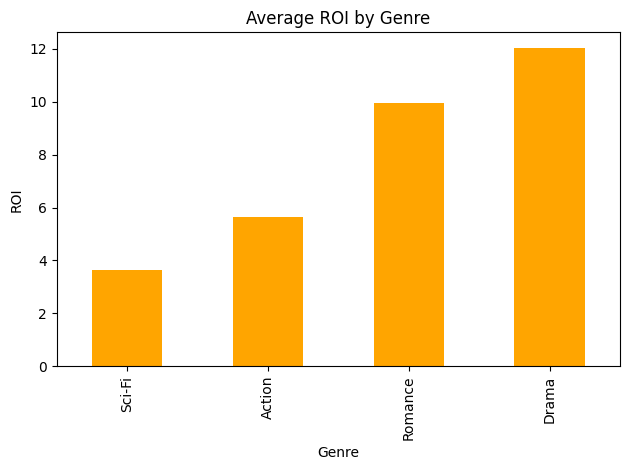

In [54]:
# Convert to Pandas
pdf = union_df.select("Genre", "ROI").toPandas()


import matplotlib.pyplot as plt

roi_plot = pdf.groupby("Genre")["ROI"].mean().sort_values()
roi_plot.plot(kind="bar", color="orange", title="Average ROI by Genre")
plt.ylabel("ROI")
plt.tight_layout()
plt.show()